In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras import regularizers
from livelossplot import PlotLossesKeras

2024-04-11 07:46:23.759181: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Khai báo các thông số
img_width, img_height = 64, 64
batch_size = 32
epochs = 100
num_classes = 3
input_shape = (img_width, img_height, 3)
n_splits = 5

In [3]:
# Đường dẫn đến thư mục chứa dữ liệu
data_dir = '../dataset_without_bmi'
dataset = 'dataset_without_bmi'

# Danh sách các lớp (classes) là các thư mục con trong thư mục chứa dữ liệu
classes = os.listdir(data_dir)
print(classes)

['torso', 'leg', 'arm']


In [4]:
# Khởi tạo StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Khởi tạo empty lists để lưu trữ các độ chính xác trên tập validation của mỗi fold
val_accuracies = []

# Tạo empty lists để lưu trữ đường dẫn hình ảnh và nhãn tương ứng
image_paths = []
labels = []

In [5]:
# Lặp qua mỗi lớp
for class_label in classes:
  class_dir = os.path.join(data_dir, class_label)
  # Lặp qua mỗi hình ảnh trong mỗi lớp
  for image_name in os.listdir(class_dir):
    image_path = os.path.join(class_dir, image_name)
    image_paths.append(image_path)
    labels.append(class_label)

In [6]:
# Tạo ImageDataGenerator cho tập huấn luyện
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Tạo ImageDataGenerator cho tập validation, chỉ cần rescale lại giá trị pixel
val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Load pre-trained ResNet50 model without top layer
base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Combine base model and custom layers into a new model
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
# Freeze layers in base model
for layer in base_model.layers:
    layer.trainable = True

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 70, 70, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 32, 32,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 32, 32,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 32, 32,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 34, 34,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 16, 16,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 16, 16,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 16, 16,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 16, 16,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 16, 16,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 16, 16,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 16, 16,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 16, 16,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 16, 16,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 16, 16,    │      1,024 │ conv2_block1_3_c

 Total params: 25,693,059 (98.01 MB)

 Trainable params: 25,637,891 (97.80 MB)

 Non-trainable params: 55,168 (215.50 KB)

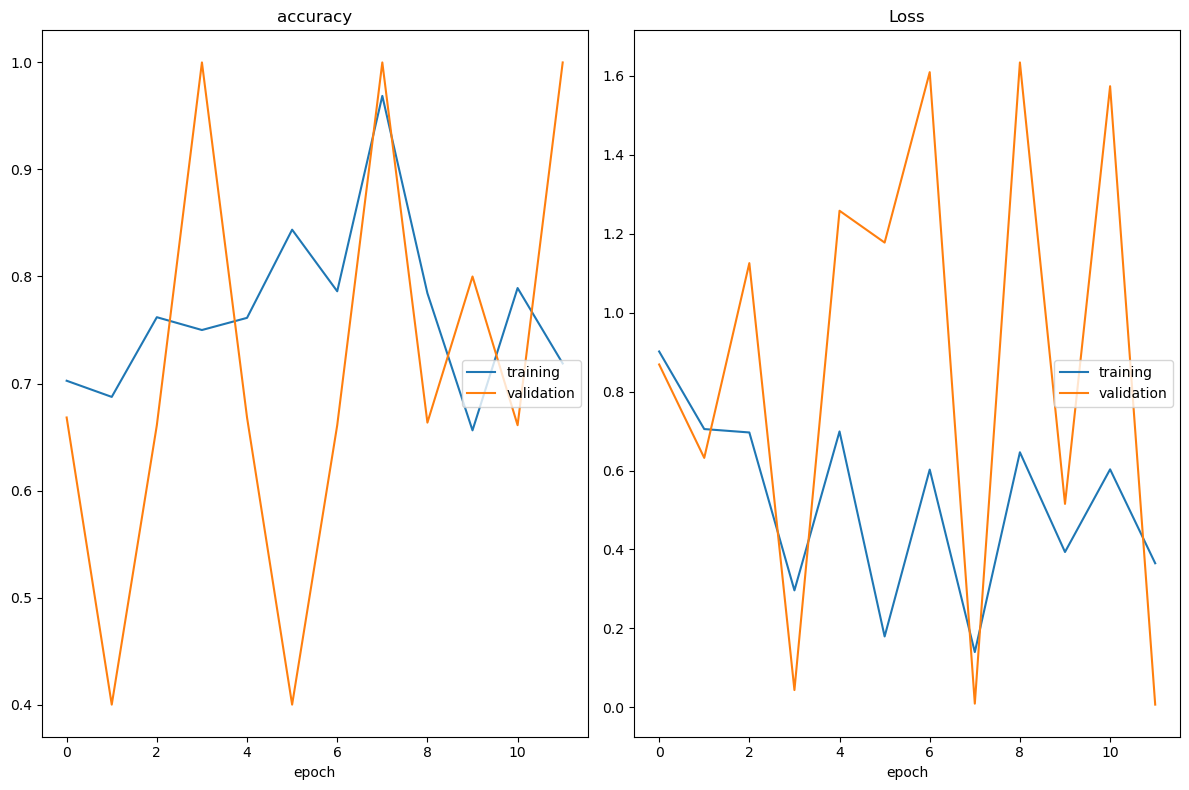

accuracy
	training         	 (min:    0.656, max:    0.969, cur:    0.719)
	validation       	 (min:    0.400, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.140, max:    0.901, cur:    0.365)
	validation       	 (min:    0.007, max:    1.633, cur:    0.007)


KeyboardInterrupt: 

In [10]:
# Lặp qua các fold
for fold, (train_index, val_index) in enumerate(skf.split(image_paths, labels)):
    print(f'Fold {fold+1}/{n_splits}')
    train_paths_fold = [image_paths[i] for i in train_index]
    val_paths_fold = [image_paths[i] for i in val_index]
    train_labels_fold = [labels[i] for i in train_index]
    val_labels_fold = [labels[i] for i in val_index]

    # Tạo DataFrame cho tập huấn luyện và tập validation của fold hiện tại
    train_fold_dataframe = pd.DataFrame({'image_path': train_paths_fold, 'label': train_labels_fold})
    val_fold_dataframe = pd.DataFrame({'image_path': val_paths_fold, 'label': val_labels_fold})

    # Tạo generator cho tập huấn luyện và tập validation của fold hiện tại
    train_fold_generator = train_datagen.flow_from_dataframe(
        dataframe=train_fold_dataframe,
        x_col="image_path",
        y_col="label",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        classes=classes
    )

    val_fold_generator = val_datagen.flow_from_dataframe(
        dataframe=val_fold_dataframe,
        x_col="image_path",
        y_col="label",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        classes=classes
    )

    # Clone mô hình
    model_clone = tf.keras.models.clone_model(model)
    model_clone.compile(optimizer=Adamax(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Huấn luyện mô hình trên fold hiện tại
    history_fold = model_clone.fit(
        train_fold_generator,
        steps_per_epoch=train_fold_generator.samples // batch_size,
        epochs=epochs,
        validation_data=val_fold_generator,
        validation_steps=val_fold_generator.samples // batch_size,
        verbose=0,
        callbacks=[PlotLossesKeras()]
    )

    # Lưu trữ độ chính xác trên tập validation của fold hiện tại
    val_accuracies.append(history_fold.history['val_accuracy'][-1])

In [ ]:
# In ra độ chính xác trung bình trên tập validation của tất cả các fold
print(f'Average validation accuracy across {n_splits} folds: {np.mean(val_accuracies)}')